# Carregar as bibliotecas

In [1]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure
from scipy import ndimage, stats, fft
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def show(img_list, caption_list):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        ax[i].imshow(img_list[i], cmap='gray')
        ax[i].set_title(caption_list[i])

In [3]:
def gridFourier(M, N):
    u = np.arange(0, M)
    v = np.arange(0, N)
 
    u = u - np.floor(M/2)
    v = v - np.floor(N/2)
    U, V = np.meshgrid(u, v)
    return U, V

# Questão 1

<p align="justify">
Dada a seguinte imagem, eliminar o ruído produzido pelo ruído periódico. Teste com os seguinte filtros: média, mediana e a filtragem no domínio da frequência. Para o caso da filtragem no domínio da frequência, primeiro calcule o espectro de Fourier (Figura b) e elimine a \textbf{região} ao redor dos ``spikes'' (assinalados com a seta vermelha). Os ``spikes'' estão localizados nas coordenadas (88,88) e (170,170). A terceira imagem mostra o processo depois de apagar esses valores.
Para apagar os valores, basta atribuir zero para todos os elementos da região.
</p>

<p align="justify">

</p>

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1BGJbV6sXNNlt2PmIZ7RCyHpQfPRpZgJ6" alt="Drawing"  width="300"/> </td>

</tr></table>

<p align"justify">
Filtro notch: São filtros capazes de rejeitar uma faixa bastante estreita de frequências. Sua utilização é recomendada quando o sinal a ser atenuado é bem definido. Pelo fato de atuar em faixas reduzidas de frequências, filtros notch interferem pouco na qualidade do sinal. A figura a continuação mostra apenas um par de regiões sendo retirado.
</p>

<img src="https://drive.google.com/uc?id=1L4J9Y6yFpKMebHyceWb1cy7j6CWljixO" alt="Drawing"  width="300"/>

<p align"justify">
A área em torno da frequência de corte escolhida ($D_0$) que pode ser retirada é definida na construção do filtro. Seja $D_0$ a frequência de corte do filtro notch centrado em ($u_0, v_0$) e, por simetria ($-u_0, -v_0$):

$$D_1(u,v) = \sqrt{(u - M/2 - u_0)^2 + (v - N/2 - v_0)^2}$$

$$D_2(u,v) = \sqrt{(u - M/2 + u_0)^2 + (v - N/2 + v_0)^2}$$

$$H(u,v) = \frac{1}{1 + \left(\frac{D_0^2}{D_1(u,v)D_2(u,v)}\right)^n}$$

Crie um filtro notch para remover a ruído periódico
</p>


In [5]:
def mask_butterworth_notch(width, height, d0, n, u, v):
    M=width
    N=height
    u0=M/2
    v0=N/2

    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    W = np.sqrt(u**2 + v**2)

    D1=np.sqrt( (U-u)**2 + (V-v)**2 )
    D2=np.sqrt( (U+u)**2 + (V+v)**2 )
    #H = 1 / (1 + ( (D*W)/(D**2 - d0**2))**(2*n))
    H = 1 / (1 + ( ( D**2 / (D1 * D2) ) ** n ))
    #H = 1 / (1 + ( (d0**2) / D1 * D2 ) ** n )
    return H

In [6]:
def passa_freq(img, mask):
    height, width = img.shape[:2]
    fimg = fft.fftshift( fft.fft2(img) )
    fimg = fimg * mask
    nimg = fft.ifft2(fimg)
    nimg = np.abs(nimg)
    return nimg, fimg

In [7]:
lenna = io.imread('https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL', as_gray=True)

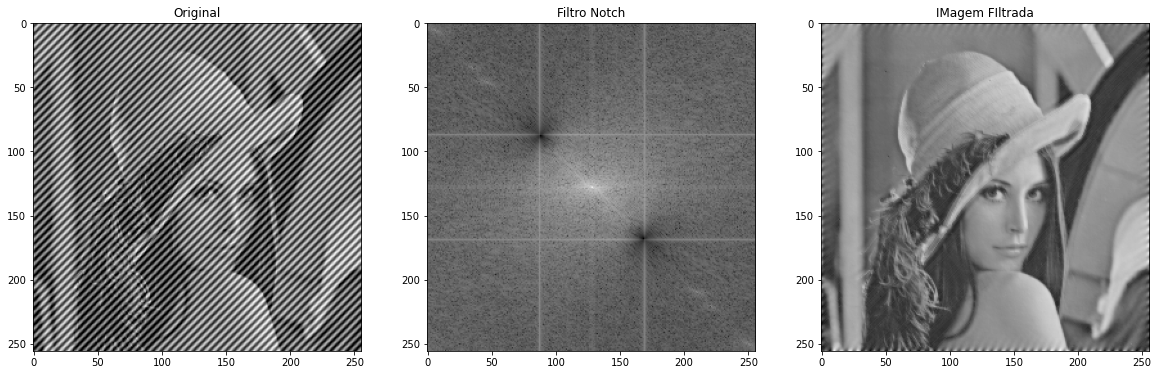

In [8]:
lin, col = lenna.shape[:2]
#HN = mask_butterworth_notch(col, lin, 50, 3, 40, 40)
HN = mask_butterworth_notch(col, lin, 58, 3, 40, 40)
nimg, fimg = passa_freq(lenna, HN)

show([lenna, np.log(np.abs(fimg)+1), nimg], ['Original','Filtro Notch', 'IMagem FIltrada'])





# Questão 2
<p align="justify">
Repita o processo de remoção do ruído periódico da questão anterior utilizando os seguintes filtro passa-bandas: ideal, Butterworth e Gaussiano.
<p>

<p align="justify">
Filtro Ideal:
$$H(u,v) = \begin{cases}
0 & \text{se } D_0-\frac{W}{2} \leq D \leq D_0 + \frac{W}{2}\\
1 & \text{otherwise}
\end{cases} $$
<p>

<p align="justify">
Filtro Butterworth:
$$H(u,v) = \frac{1}{1 + \left(\frac{D.W}{D^2 - D_0^2}\right)^{2n}}$$
<p>

<p align="justify">
Filtro Gaussiano:
$$H(u,v) = 1 - e^{\left(-  \frac{D^2 - D_0^2}{D.W} \right)^2}$$
<p>

In [64]:
def mask_ideal_band(width, height, d0, W):
  u=0
  v=0
  H=np.ones((width, height))
  U, V = gridFourier(width, height)
  D = np.sqrt(U**2 + V**2)
  D1=np.sqrt( (U-u)**2 + (V-v)**2 )
  D2=np.sqrt( (U+u)**2 + (V+v)**2 )
  for i in range(len(U)):
    for j in range(len(V)):
      if(d0-W/2<=D[i,j] and D[i,j]<=d0+W/2):
        H[i,j]=0
  return H

In [43]:
def mask_butterworth_band(width, height, d0, n, W):
    v=d0
    u=d0

    U, V = gridFourier(width, height)
    
    D = np.sqrt(U**2 + V**2)
    
    D1=np.sqrt( (U-u)**2 + (V-v)**2 )
    D2=np.sqrt( (U+u)**2 + (V+v)**2 )

    H = 1 / (1 + ( (D*W)/(D**2 - d0**2))**(2*n))
    
    return H

In [62]:
def mask_gaussian_band(width, height, d0,  W):
    
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)

    H = 1 - np.exp( ( -( (D**2-d0**2) / (D*W) ) )**2)
    print(H)

    return H

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


[[-574495.91134065 -423390.42588704 -313652.87251162 ... -233566.97154747
  -313652.87251162 -423390.42588704]
 [-423390.42588704 -312151.90450875 -231339.88041366 ... -172343.33028798
  -231339.88041366 -312151.90450875]
 [-313652.87251162 -231339.88041366 -171520.89088066 ... -127834.72521398
  -171520.89088066 -231339.88041366]
 ...
 [-233566.97154747 -172343.33028798 -127834.72521398 ...  -95317.94615645
  -127834.72521398 -172343.33028798]
 [-313652.87251162 -231339.88041366 -171520.89088066 ... -127834.72521398
  -171520.89088066 -231339.88041366]
 [-423390.42588704 -312151.90450875 -231339.88041366 ... -172343.33028798
  -231339.88041366 -312151.90450875]]


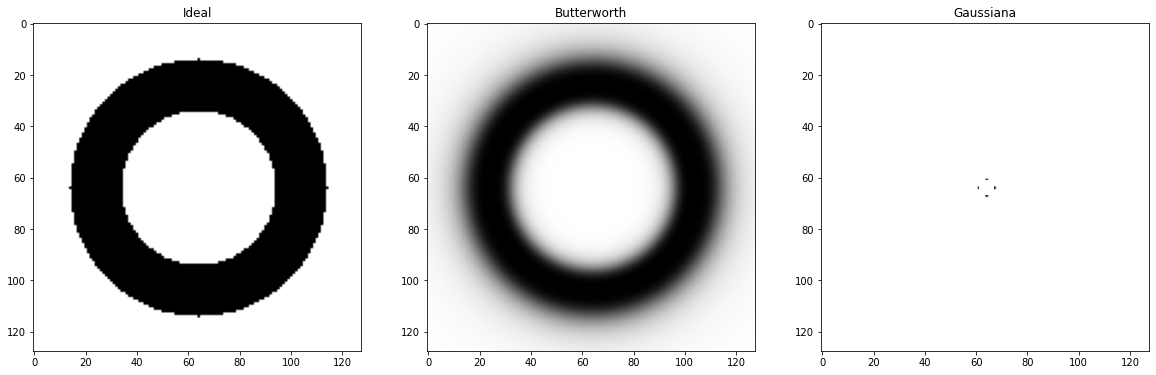

In [63]:
HI =  mask_ideal_band(128, 128, 40, 20)
HB =  mask_butterworth_band(128, 128, 40, 2, 20)
HG =  mask_gaussian_band(128, 128, 40, 20)
show([HI, HB, HG], ['Ideal','Butterworth', 'Gaussiana'])


In [48]:
lenna = io.imread('https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL', as_gray=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


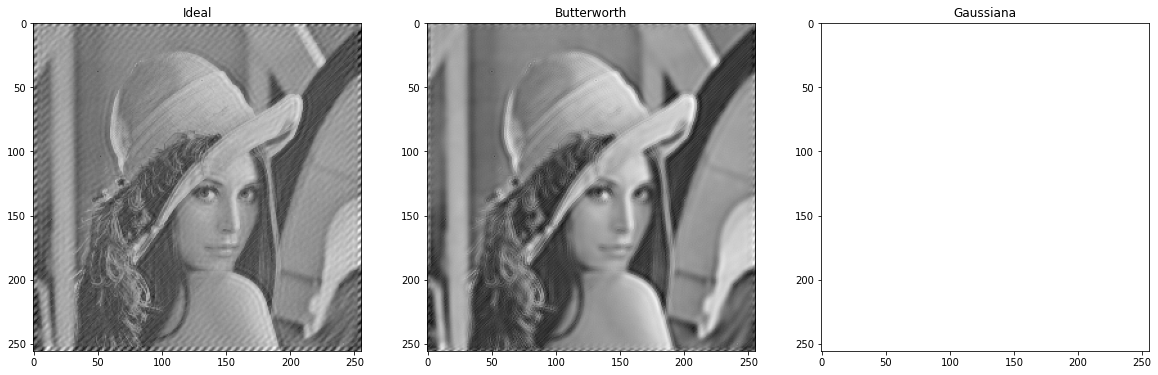

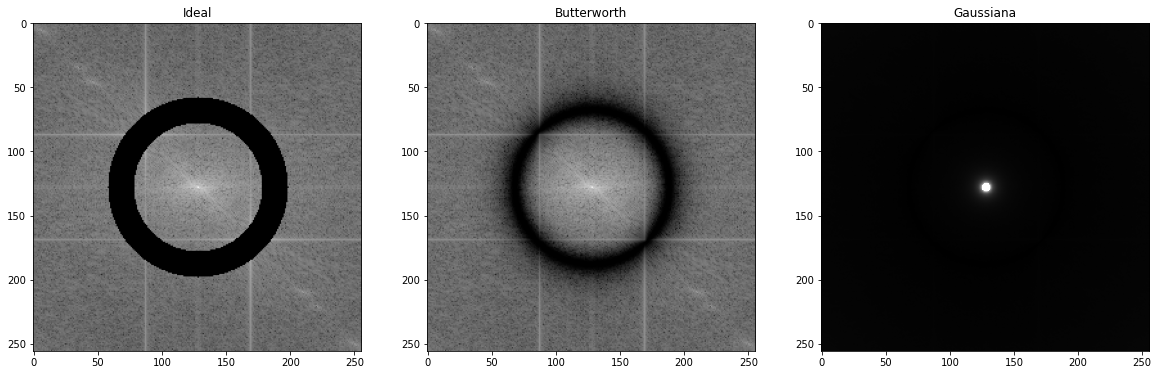

In [49]:
lin, col = lenna.shape[:2]

HI =  mask_ideal_band(col, lin, 60, 20)
HB =  mask_butterworth_band(col, lin, 60, 2, 50)
HG =  mask_gaussian_band(col, lin, 60, 50)
nimgI, fimgI = passa_freq(lenna, HI)
nimgB, fimgB= passa_freq(lenna, HB)
nimgG, fimgG = passa_freq(lenna, HG)

show([nimgI, nimgB, nimgG], ['Ideal','Butterworth', 'Gaussiana'])
show([np.log(np.abs(fimgI)+1), np.log(np.abs(fimgB)+1), np.log(np.abs(fimgG)+1)], ['Ideal','Butterworth', 'Gaussiana'])

# Questão 3: Machine Learning

## Base de datos Iris

<img src="https://drive.google.com/uc?id=1r_fDDsCLOCQVbhLldmdNfoyuCPH-VvwK" alt="Drawing"  width="900"/>



<ul>
    <li>50 exemplos de 3 diferentes especies de flores de iris</li>
    <li>Medidas:  o comprimento e a largura das sépalas e pétalas, em centímetros </li>
</ul>

## Carregando a base Iris

In [65]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris

In [66]:
iris = load_iris()
print(f'Informações presentes no dataset: {iris.keys()}')
print(f'Atributos do conjunto de dados: {iris.feature_names}')
print(f'Nomes das classes: {iris.target_names}')
print(f'Tamanho dos dados: {iris.data.shape}')
print(f'Tamanho das etiquetas: {iris.target.shape}')

Informações presentes no dataset: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
Atributos do conjunto de dados: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Nomes das classes: ['setosa' 'versicolor' 'virginica']
Tamanho dos dados: (150, 4)
Tamanho das etiquetas: (150,)


In [67]:
print(iris.data)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

## Terminología

<ul>
  <li>Cada linha é uma observação (também conhecida como: amostra, exemplo, instância, registro - <i> sample, example, instance, record</i>)</li>
  <li>Cada coluna é um característica (também conhecido como: preditor, atributo, variável independente, entrada, regressor, covariável - <i>predictor, attribute, independent variable, input, regressor, covariate</i>)</li>
</ul>

## Requisitos para trabalhar com dados no scikit-learn
<ul>
  <li>Características (atributos) e etiquetas são objetos separados</li>
  <li>As características e etiquetas devem ser numéricos</li>
  <li>As características e etiquetas devem ser matrizes NumPy</li>
  <li>As características e etiquetas devem ter formas específicas</li>
</ul>

## Padrão de modelagem de 4 etapas scikit-learn

<b>Passo 1</b>: importe a classe que você planeja usar

In [68]:
from sklearn.neighbors import KNeighborsClassifier

<b>Passo 2</b>: "Instanciar" o "estimador"
<ul>
  <li>"Estimator" é o termo do scikit-learn para modelo</li>
  <li>"Instanciar" significa "criar uma instância de"</li>

</ul>

In [69]:
knn = KNeighborsClassifier(n_neighbors=1)

<ul>
  <li>O nome do objeto não importa</li>
  <li>Pode especificar parâmetros de ajuste (também conhecidos como "hiperparâmetros") durante esta etapa</li>
  <li>Todos os parâmetros não especificados são definidos para seus padrões</li>

</ul>

In [70]:
# mostrando informações do modelo
print(knn)

KNeighborsClassifier(n_neighbors=1)


<b>Passo 3</b>: ajustar o modelo com os dados (também conhecido como "treinamento de modelo")
<ul>
  <li>O modelo está aprendendo a relação entre $X$ e $y$</li>
  <li>O treino acontece no proprio objeto</li>
</ul>

In [71]:
# características
X = iris.data

# etiquetas
y = iris.target

knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

<b>Passo 4</b>: predizer a resposta para uma nova observação
<ul>
  <li>Novas observações são chamadas de dados "fora da amostra"</li>
  <li>Usa as informações que aprendeu durante o processo de treinamento do modelo</li>
</ul>


In [72]:
knn.predict([[3, 5, 4, 2]])

array([2])

<p> Segundo o classificador, o dado fornecido pertence à terceira classe </p>

# Processamentos dos dados
## Normalizar os dados

<p>O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores.</p>

<p>Normalização</p>
$$X_{new} = \frac{ X - X_{min} }{ X_{max} - X_{min} }$$

<p>Padronização</p>
$$X_{changed} = \frac{ X - \mu }{ \sigma } $$

<p>Importando o módulo de preprocessamento</p>

In [73]:
from sklearn import preprocessing


<p>Normalizando e padronizando os dados da base Iris</p>

In [74]:
# normalização
#X_new = preprocessing.MinMaxScaler().fit_transform(X)
minmax_scaler = preprocessing.MinMaxScaler().fit(X)
X_new = minmax_scaler.transform(X)

# padronização
std_scaler = preprocessing.StandardScaler().fit(X)
X_changed = std_scaler.transform(X)

## Separar o conjunto de dados em subconjuntos disjuntos
<ul>
  <li>Treino</li>
  <li>Validação</li>
  <li>Teste</li>
</ul>
<p>Carregando o módulo para dividir a base de dados</p>

In [75]:
# permite dividir o conjunto de dados en treino e teste
from sklearn.model_selection import train_test_split

<p>A base é dividida em dois subconjuntos</p>
<ul>
  <li>x_train: dados (atributos) de treino</li>
  <li>x_test: dados para teste</li>
  <li>y_train: etiquetas do conjunto de treino</li>
  <li>y_test: etiquetas do conjunto de teste</li>
</ul>

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)

##Seguir os 4 passos de modelagem de scikit-learn

Padrão de modelagem de 4 passos scikit-learn
* Passo 1: importe a classe que você planeja usar
* Passo 2: "Instanciar" o "estimador"
* Passo 3: ajustar o modelo com os dados (também conhecido como "treinamento de modelo"
* Passo 4: predizer a resposta para uma nova observação


In [77]:
# Passo 1
from sklearn.neighbors import KNeighborsClassifier
# Passo 2
knn = KNeighborsClassifier(n_neighbors=1)
# Passo 3
knn.fit(x_train, y_train)
# Passo 3
pred = knn.predict(x_test)

## Calcular a acurácia por classe usando uma matriz de confusão

<p>Usar a funçõa <i>metrics.confusion_matrix(y_test, pred)</i>, onde <i>y_test</i> são as verdadeiras etiquetas do conjunto de teste, e <i>y_pred</i> são as etiquetas preditas pelo classificador treinado.</p>

In [78]:
from sklearn import metrics

In [79]:
m = metrics.confusion_matrix(y_test, pred)
tot = np.sum(m, axis=1, keepdims=True) 
np.set_printoptions(precision=2)
m_porc = m/tot

print(f'Matriz de confusão:\n {m_porc}')

print(f'Acuracia média: {np.mean ( m_porc.diagonal() ): 0.2}' )

Matriz de confusão:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Acuracia média:  1.0


<p>Use o classificador SVM para classificar a base Wine </p>

In [190]:
case=2

In [191]:
from sklearn.datasets import load_wine
wine = load_wine()

In [192]:
X = wine.data

y = wine.target

In [193]:
# Passo 1
from sklearn import svm

In [194]:
# Passo 2
clf_svm = svm.SVC(C=5, kernel='linear')


<p>A função <i>train_test_split</i> pode retornar os índices das amostradas selecionadas para treinar e testar. Use esses índices para seleccionar o mesmo conjunto de dados: </p> 

*   sem normalizar ($X$) 
*   normalizados ($X_{new}$), e 
*   padronizados ($X_{changed}$).



In [195]:
indices = np.arange(X.shape[0])
(
    x_train,
    x_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.2)

<p> Verificar se os índices de treino correspondem com os dados atribuidos a <i>x_train</i></p>

In [196]:
amostra_treino = x_train[:5, :]
print(f'x_train: \n: {amostra_treino}')

amostra_indice_treino = X[ indices_train[:5] , :]
print(f'dados de treino usando os índices: \n: {amostra_indice_treino}')

x_train: 
: [[1.31e+01 1.50e+00 2.10e+00 1.55e+01 9.80e+01 2.40e+00 2.64e+00 2.80e-01
  1.37e+00 3.70e+00 1.18e+00 2.69e+00 1.02e+03]
 [1.18e+01 2.13e+00 2.78e+00 2.85e+01 9.20e+01 2.13e+00 2.24e+00 5.80e-01
  1.76e+00 3.00e+00 9.70e-01 2.44e+00 4.66e+02]
 [1.21e+01 2.16e+00 2.17e+00 2.10e+01 8.50e+01 2.60e+00 2.65e+00 3.70e-01
  1.35e+00 2.76e+00 8.60e-01 3.28e+00 3.78e+02]
 [1.18e+01 1.72e+00 1.88e+00 1.95e+01 8.60e+01 2.50e+00 1.64e+00 3.70e-01
  1.42e+00 2.06e+00 9.40e-01 2.44e+00 4.15e+02]
 [1.29e+01 2.99e+00 2.40e+00 2.00e+01 1.04e+02 1.30e+00 1.22e+00 2.40e-01
  8.30e-01 5.40e+00 7.40e-01 1.42e+00 5.30e+02]]
dados de treino usando os índices: 
: [[1.31e+01 1.50e+00 2.10e+00 1.55e+01 9.80e+01 2.40e+00 2.64e+00 2.80e-01
  1.37e+00 3.70e+00 1.18e+00 2.69e+00 1.02e+03]
 [1.18e+01 2.13e+00 2.78e+00 2.85e+01 9.20e+01 2.13e+00 2.24e+00 5.80e-01
  1.76e+00 3.00e+00 9.70e-01 2.44e+00 4.66e+02]
 [1.21e+01 2.16e+00 2.17e+00 2.10e+01 8.50e+01 2.60e+00 2.65e+00 3.70e-01
  1.35e+00 2.76e+00 8

In [197]:
# normalização
if(case>=1):
  minmax_scaler = preprocessing.MinMaxScaler().fit(X)
  X_new = minmax_scaler.transform(X)

# padronização
if(case>=2):
  std_scaler = preprocessing.StandardScaler().fit(X)
  X_changed = std_scaler.transform(X)

In [198]:
if(case==0):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
else:
  x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)

In [199]:
if(case==0):
 clf_svm.fit(x_train, y_train)
 pred0 = clf_svm.predict(x_test)

if(case==1):
 clf_svm.fit(x_train, y_train)
 pred1 = clf_svm.predict(x_test)

if(case==2):
 clf_svm.fit(x_train, y_train)
 pred2 = clf_svm.predict(x_test)

<p>Calcule a taxa de acerto para cada tipo de conjunto de dados (sem normalizar, normalizado e padronizado). Para cada novo treino, instancie um novo modelo

In [178]:
if(case==0):
  m = metrics.confusion_matrix(y_test, pred0)
  tot = np.sum(m, axis=1, keepdims=True) 
  np.set_printoptions(precision=2)
  m_porc = m/tot

  print(f'Matriz de confusão:\n {m_porc}')

  print(f'Acuracia média: {np.mean ( m_porc.diagonal() ): 0.2}' )

Matriz de confusão:
 [[0.91 0.09 0.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]]
Acuracia média:  0.97


In [189]:
if(case==1):
  m = metrics.confusion_matrix(y_test, pred1)
  tot = np.sum(m, axis=1, keepdims=True) 
  np.set_printoptions(precision=2)
  m_porc = m/tot

  print(f'Matriz de confusão:\n {m_porc}')

  print(f'Acuracia média: {np.mean ( m_porc.diagonal() ): 0.2}' )

Matriz de confusão:
 [[1.   0.   0.  ]
 [0.06 0.94 0.  ]
 [0.   0.   1.  ]]
Acuracia média:  0.98


In [200]:
if(case==2):
  m = metrics.confusion_matrix(y_test, pred2)
  tot = np.sum(m, axis=1, keepdims=True) 
  np.set_printoptions(precision=2)
  m_porc = m/tot

  print(f'Matriz de confusão:\n {m_porc}')

  print(f'Acuracia média: {np.mean ( m_porc.diagonal() ): 0.2}' )

Matriz de confusão:
 [[1.   0.   0.  ]
 [0.   0.91 0.09]
 [0.   0.   1.  ]]
Acuracia média:  0.97
